# Lab-Audio Speech Recognition using DTW


- Initially proposed by Chloé Clavel / Matthieu Labeau (original lab by Olivier Cappé)
- Largely re-written by Geoffroy Peeters (2023/12/04)
    - clean code, create functions (reduce a lot of redundancy), change DTW
    - correct true positif, false positif, ...



## Coding

In the following, variables that end with
- `$_d` are dictionaries
- `$_l` are lists
- `$_v`/ `$_m` are numpy array of dim=1 (vectors) or dim=2 (matrices)

We will use extensively dictionary to help passing data from/to function and for code clarity.

In [2]:
do_student = True

import os
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


from scipy.io import wavfile
from sklearn.preprocessing import normalize

## Data

We have three directories :
- ```SIG``` contains 12 repetitions (`Rep_1:12`) of numbers from 0 to 9 (`Number_0:9`) by speaker1 (sample\_rate = 8000kHz).
    - For example `SIG_Rep_5_Number_3.wav` is the recording corresponding to the fifth repetition of the number “3” .
- ```SIG2```, contains 6 repetitions of numbers from 0 to 9 by speaker2
- ```SIG_MIXED``` contains 6 repetitions of the numbers by speaker1 (`SIG_MIXED_Rep_1:6`) and then by speaker2 (`SIG_MIXED_Rep_7:12`).

In [3]:
import urllib.request
urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1xA_PtfRxkE-aFWhW7lQEnf0eR8rO4J8N', 'Data.zip');
import shutil
shutil.unpack_archive('Data.zip', './', 'zip')

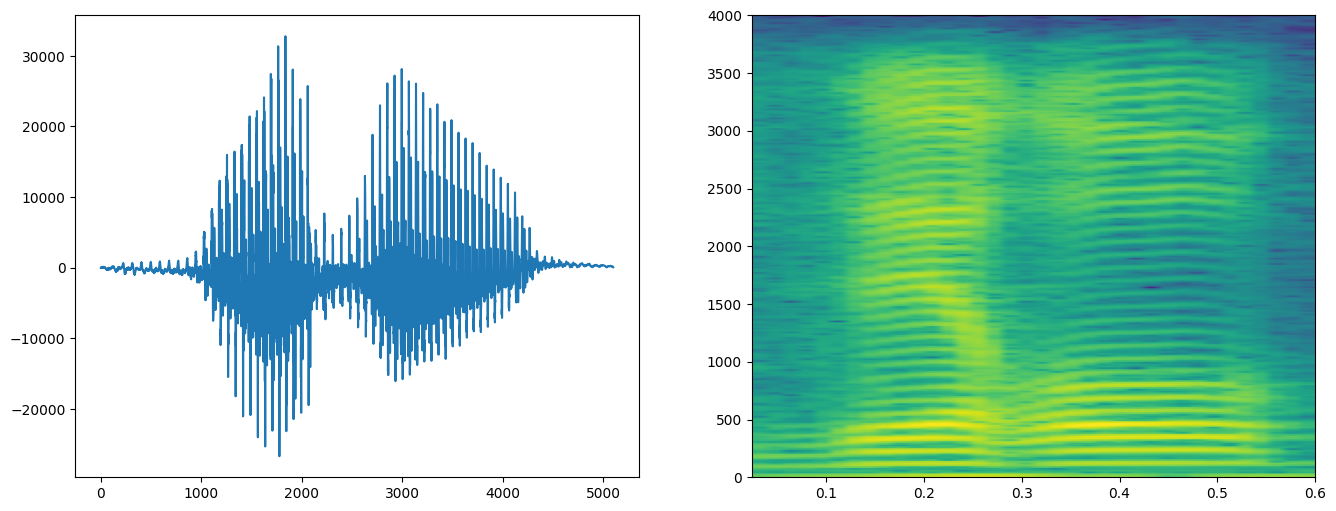

In [4]:
entry_d = {}

entry_d['file_path'] = "./SIG/SIG_Rep_1_Number_0.wav"
entry_d['sample_rate'], entry_d['wav_v'] = wavfile.read(entry_d['file_path'])

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(entry_d['wav_v'])
plt.subplot(122)

N = 512
plt.specgram(entry_d['wav_v'], Fs=entry_d['sample_rate'], NFFT=N, noverlap=int(3/4*N))

import IPython
IPython.display.Audio(entry_d['file_path'])

## Speech Feature Extraction

Write a python function ```F_feature_extraction``` to calculate the cepstral parameterization associated with each pronunciation. With regard to the parameters of the analysis, we will make the following choices:
- **Parameterization type**: Cepstrum (real number) using linear frequency scale (as opposed to Mel-frequency cepstrum) and computed using FFT (Fast Fourier Transform)
- **Weigthing window**: Hanning

The inputs of the function will be the following:
- **Wav data**: The data extracted from a .wav file
- **Window size**: 256 samples (32 ms)
- **Window shift**: 128 samples
- **Cepstral order**: p = 10


For each signal, the result of the analysis is a sequence of parameters that will be stored as a list of vectors
according to the following convention:

$$ \quad X = \underbrace{\left[\begin{array}{c}
 X_1 \\
 X_2 \\
 \vdots \\
 X_{l_X}
\end{array} \right]}_p  $$

Each element of the list $X_i$ represent the cepstral representation for time frame $i$, it is a vector of size $p$.
Note that the number of ceptral vectors obtained ($l_X$) depends on the length of the signal, so it is variable.
We obtain one list of this type for each audio signal.

In [5]:
def F_feature_extraction(wav_v, window_size, window_shift, cepstral_order):
    """
    Indication: use the numpy functions np.hanning, np.fft.fft, and np.fft.ifft.
    Use the attribute .real to take the real part of complex numbers that are output by np.fft.ifft
    Don't hesitate to look at the numpy documentation to get a better understanding of what the functions do !

    Args:
        wav_v
        window_size
        window_shift
        cepstral_order
    Outputs:
        cepstral_vectors_l: list of cesptral vectors, each element of the list is one cepstral vector, each vector is a np.array of size (cepstral_order)
    """

    cepstral_vectors_l = []
    window = np.hanning(window_size)
    for i in range(0, len(wav_v) - window_size, window_shift):
        frame = wav_v[i:i+window_size]
        frame = frame * window
        spectrum = np.fft.fft(frame)
        log_spectrum = np.log(np.abs(spectrum) + 1e-10)
        cepstral = np.fft.ifft(log_spectrum).real
        cepstral_vectors_l.append(cepstral[:cepstral_order])

    return cepstral_vectors_l

In [6]:
# Example !
window_size = 256
window_shift = 128
cepstral_order = 10
entry_d['cepstral_vectors_l'] = F_feature_extraction(entry_d['wav_v'], window_size, window_shift, cepstral_order)

In [7]:
print(f"number of frames: { len(entry_d['cepstral_vectors_l']) } / number of cepstral coefficients: { len(entry_d['cepstral_vectors_l'][0]) }")

number of frames: 38 / number of cepstral coefficients: 10


## Time Alignment by Dynamic Programming

Write a python function ```F_time_alignment(x, y, gamma)``` performing time alignment by dynamic programming between two sequences of vectors stored with the convention above. The Euclidean norm between the following vectors and time
constraints will be used:

\begin{matrix}
  \bullet & \rightarrow & \bullet\\
   & \nearrow_{\gamma} & \uparrow\\
  \bullet & & \bullet
\end{matrix}

with a diagonal weighting $\gamma$ that may be chosen different from 1. It is essential to carry out this function in a parameterized way in order to be able to validate it on the mono-dimensional example being studied.
The function will take as **inputs** the two vector sequences $(X_1, \dots, X_{l_X})$ et $(Y_1, \dots, Y_{l_Y})$ stored in the two matrices, as well as the parameter $\gamma$. It will then execute the following operations:
- **Calculation of the similarity matrix**: Given the two vector sequences, calculate the matrix $D (l_X \times l_Y)$ such that $D(i,j) = \|X_i-Y_j\|$.
- **Initialization of the cumulative distance matrix**: Calculate the content of the first row and column of the cumulative distance matrix $C (l_X \times l_Y)$ such that $C(i,j)$ contains the cumulative distance along the minimum cumulative distance path joining the node $(i,j)$ at the initial node $(1,1)$.
- **Calculation of the matrix of cumulative distances**: For $i$ ranging from 2 to $\min(l_X,l_Y)$, calculation of $C(i,i)$ then $C(i+1,i), \dots C(l_X,i)$ and $C(i,i+1), C(i,i+2), \dots C(i,l_Y)$ (you will recall what justifies this way to proceed). To store the predecessor along the optimal path leading to $(i,j)$, you can use a three-dimensional array $B (l_X \times l_Y \times 2)$ since the predecessor is a node of the network defined by its two coordinates (we can alternatively use a "code" representing the three possible predecessors).
- ***Bactracking***: From the node $(l_X,l_Y)$, reconstruction of the optimal path (starting from the end).

Finally, the **output** will be the cumulative distance along the path of least cost  (```distance```) and the alignment path (```M```), in the form of the matrix  $M$  with two columns such that $X_{M(i,1)}$  is the vector mapped to $Y_{M(i,2)}$ (note that the number of lines in this matrix corresponding to the length of the optimal path is variable). The function can also return the matrix of cumulative distances (```C```).

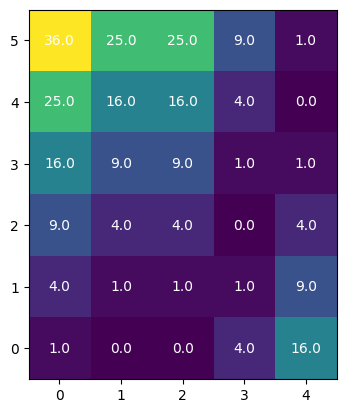

In [8]:
B_l = [np.array([num]) for num in [2,3,4,5,6,7]]
A_l = [np.array([num]) for num in [1,2,2,4,6]]
C_m = cdist(B_l, A_l, metric="euclidean")**2

fig, ax = plt.subplots()
ax.imshow(C_m, origin='lower')
n_max, m_max = C_m.shape
for n in range(n_max):
    for m in range(m_max):
        c = C_m[n,m]
        ax.text(m, n, str(c), va='center', ha='center', color='white')


In [9]:
def F_time_alignment(X_l, Y_l, gamma):
    """
    Args:
        - X_l, Y_l: two vector sequences.
        - gamma: parameter for weighting the diagonal path
    Outputs:
        - D_cumul: np.array representing the matrix of cumuluted cost for each (n,m)
        - warping_path_l: list of tuple (n,m) given the optimal path to align X_l and Y_l
        - final_score: final normalized score
    """

    #gamma = 2
    #X_l = [np.array([num]) for num in [2,3,4,5,6,7]]
    #Y_l = [np.array([num]) for num in [1,2,2,4,6]]

    len_x, len_y = len(X_l), len(Y_l)
    # --- (m_b, n) (m_a, n)  -> sqrt( \sum(x-y)^2 ) -> attention dans les transparents c'est \sum(x-y)^2
    C_m = cdist(X_l, Y_l, metric="euclidean")**2

    # --- Define the possible paths, and for each one weight_add and weight_mul
    path_l = []
    path_l.append({'prev_n':1, 'prev_m': 1, 'w_add':0, 'w_mul':gamma})
    path_l.append({'prev_n':0, 'prev_m': 1, 'w_add':0, 'w_mul':1})
    path_l.append({'prev_n':1, 'prev_m': 0, 'w_add':0, 'w_mul':1})
    extend_n = max([path['prev_n'] for path in path_l])
    extend_m = max([path['prev_m'] for path in path_l])

    # Initialize the cumulated cost matrix
    D_cumul_m = np.full((len_x + extend_n, len_y + extend_m), np.inf)
    D_cumul_m[0, 0] = 0
    D_cumul_m[extend_n, extend_m] = C_m[0, 0]

    backtrack_m = np.zeros((len_x + extend_n, len_y + extend_m), dtype=dict)
    # Compute the cumulated cost matrix
    for n in range(extend_n, len_x + extend_n):
        for m in range(extend_m, len_y + extend_m):
            for path in path_l:
                prev_n, prev_m = path['prev_n'], path['prev_m']
                if n - prev_n >= 0 and m - prev_m >= 0:
                    # cost = C_m[n - extend_n, m - extend_m] + path['w_add'] + path['w_mul'] * D_cumul_m[n - prev_n, m - prev_m]
                    cost = D_cumul_m[n - prev_n, m - prev_m] + path['w_add'] + path['w_mul'] * C_m[n - extend_n, m - extend_m]
                    if cost < D_cumul_m[n, m]:
                        D_cumul_m[n, m] = cost
                        backtrack_m[n,m] = path

    # Backtrack the optimal path
    warping_path_l = []
    weight_sum = 0
    n, m = len_x + extend_n - 1, len_y + extend_m - 1
    while n > extend_n or m > extend_m:
        path = backtrack_m[n, m]
        warping_path_l.append((n - extend_n, m - extend_m))
        prev_n, prev_m = path['prev_n'], path['prev_m']
        weight_sum += path['w_mul']
        n, m = n - prev_n, m - prev_m
    warping_path_l.reverse()
    final_score = D_cumul_m[len_x + extend_n - 1, len_y + extend_m - 1] / weight_sum

    return D_cumul_m, warping_path_l, final_score

## Example of time alignment

In [10]:
entry1_d = {}
entry1_d['file_path'] = "./SIG/SIG_Rep_1_Number_0.wav"
entry1_d['sample_rate'], entry1_d['wav_v'] = wavfile.read(entry1_d['file_path'])
entry1_d['cepstral_vectors_l'] = F_feature_extraction(entry1_d['wav_v'], window_size, window_shift, cepstral_order)

entry2_d = {}
entry2_d['file_path'] = "./SIG/SIG_Rep_2_Number_0.wav"
entry2_d['sample_rate'], entry2_d['wav_v'] = wavfile.read(entry2_d['file_path'])
entry2_d['cepstral_vectors_l'] = F_feature_extraction(entry2_d['wav_v'], window_size, window_shift, cepstral_order)

np.set_printoptions(precision=4)
D_cumul_m, warping_path_l, final_score = F_time_alignment(entry1_d['cepstral_vectors_l'], entry2_d['cepstral_vectors_l'], gamma=2)

Example of visualization of the optimal path

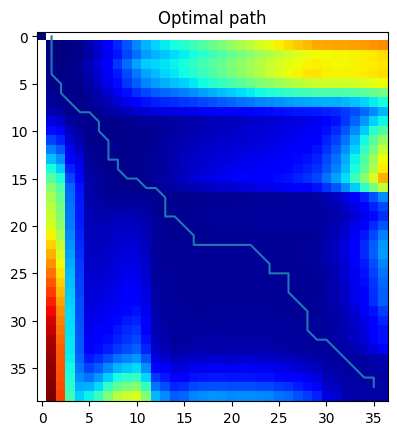

Cost of the optimal path: 0.1319646610367962


In [11]:
warping_path_m = np.array(warping_path_l)
plt.imshow(D_cumul_m, cmap='jet')
plt.title("Optimal path")
plt.plot(warping_path_m[:,1], warping_path_m[:,0])
plt.show()
print("Cost of the optimal path:", final_score)

## Applications to Speech Data

You will first work on the data from ```SIG```.

You will align a reference sequence (for example, the one corresponding to the first repetition of the first number) with all the others.
You will try to find, among all numbers of a given repetition (from 1 to 12), which one is the same one as the reference, by looking at the closest in terms of distance (of the path of least cost).

Questions:
1. Are the performances satisfactory ?
2. What is the influence of the `gamma` parameter (the weighting of the diagonal path) on the alignment paths (in order to answer, examine characteristic cases and try to judge the relevance of the alignment paths by visualizing them) ? Does this parameter have a significant influence on the obtained distance?
3. What implicit hypothesis is made when using the Euclidean distance to measure the proximity of ceptral vectors? Does this hypothesis seem acceptable to you in view of the differences between aligned sequences corresponding to different repetitions of the same word? Propose (it is not necessary to implement it!) a method to estimate from the aligned data an appropriate weighting for the comparison of ceptral vectors. Do you think this weighting could improve discrimination performance?

In [12]:
def F_do_list_files_labels(dir_path, root, nb_repetition):
    """
    List all the files within a given path

    Args:
        dir_path
        root
        nb_repetition
    Outputs:
        entry_l: list of dictionaries of type {'file': ..., 'label': ...}
    """

    entry_l = []
    for i in range(0, nb_repetition):
        for j  in range(0, 10):
            entry_d = {}
            entry_d['file_path'] = dir_path + "{}_Rep_{}_Number_{}.wav".format(root, i+1, j)
            entry_d['label'] = j
            entry_l.append(entry_d)
    return entry_l

In [13]:
def F_all_feature_extraction(entry_l):
    """
    Extract cesptral features for all the entry_d given a list entry_l

    Args:
        entry_l: list of dictionaries of type  {'file_path': ..., 'label': ...}
    Outputs:
        entry_l: list of dictionaries of type  {'file_path': ..., 'label': ..., 'cepstral_vectors_l': ...}
    """

    for entry_d in entry_l:
        entry_d['sample_rate'], entry_d['wav_v'] = wavfile.read(entry_d['file_path'])
        entry_d['cepstral_vectors_l'] = F_feature_extraction(entry_d['wav_v'], window_size, window_shift, cepstral_order)

    return entry_l

In [14]:
# Read all wave data and calculate cepstral vectors
SIG_entry_l = F_do_list_files_labels(dir_path="./SIG/", root="SIG", nb_repetition=12)
SIG_entry_l = F_all_feature_extraction(SIG_entry_l)

In [15]:
def F_discrimination(reference_d, SIG_entry_l, gamma=2, threshold=0.5):
    """
    Comptute the alignment cost of reference_d with all items in SIG_entry_l

    Args:
        - reference_d:  one dictionary of type   {'file_path': ..., 'label': ..., 'cepstral_vectors_l': ...}
        - SIG_entry_l:  list of dictionaries of type  {'file_path': ..., 'label': ..., 'cepstral_vectors_l': ...}
        - gamma: parameter for weighting the diagonal path
        - threshold: threshold to apply to the DTW normalized distance, if d < threshold then we say they are the same
    Outputs:
        - distance_l: DTW normalized distances for each entry of SIG_entry_l
        - TP, FP, FN, TN: Total (for all items of SIG_entry_l) True Positif, False Positif, False Negatif, True Negatif
    """

    distance_l = []
    TP, FP, FN, TN = 0, 0, 0, 0
    for entry_d in SIG_entry_l:
        D_cumul_m, warping_path_l, final_score = F_time_alignment(reference_d['cepstral_vectors_l'], entry_d['cepstral_vectors_l'], gamma)
        distance_l.append(final_score)
        if final_score < threshold:
            if entry_d['label'] == reference_d['label']:
                TP += 1
            else:
                FP += 1
        else:
            if entry_d['label'] == reference_d['label']:
                FN += 1
            else:
                TN += 1

    return distance_l, TP, FP, FN, TN

In [16]:
# Set first repetition of the first word as the reference sequence
reference_d = SIG_entry_l[0]
print("Reference sequence is: ", reference_d['file_path'])

gamma = 2
threshold = 0.5

# gamma = 0.5
# threshold = 0.6

distance_l, TP, FP, FN, TN = F_discrimination(reference_d, SIG_entry_l, gamma=gamma, threshold=threshold)
print(f" \t|^P\t|^N\n-----------------------\nP\t|TP:{TP}\t|FN:{FN}\nN\t|FP:{FP}\t|TN:{TN}\n")

for i in range(len(distance_l)):
    if distance_l[i] < threshold:
        print(f"{SIG_entry_l[i]['file_path']}\t{SIG_entry_l[i]['label']}\t{distance_l[i]}")

Reference sequence is:  ./SIG/SIG_Rep_1_Number_0.wav
 	|^P	|^N
-----------------------
P	|TP:12	|FN:0
N	|FP:3	|TN:105

./SIG/SIG_Rep_1_Number_0.wav	0	0.0
./SIG/SIG_Rep_1_Number_7.wav	7	0.4932622352835698
./SIG/SIG_Rep_2_Number_0.wav	0	0.1319646610367962
./SIG/SIG_Rep_3_Number_0.wav	0	0.12295599635036084
./SIG/SIG_Rep_3_Number_2.wav	2	0.4919006956342854
./SIG/SIG_Rep_4_Number_0.wav	0	0.12382348334749406
./SIG/SIG_Rep_5_Number_0.wav	0	0.10229438147450153
./SIG/SIG_Rep_6_Number_0.wav	0	0.1322619317664792
./SIG/SIG_Rep_7_Number_0.wav	0	0.11499932416912115
./SIG/SIG_Rep_8_Number_0.wav	0	0.10407145466159101
./SIG/SIG_Rep_9_Number_0.wav	0	0.17094526014745323
./SIG/SIG_Rep_10_Number_0.wav	0	0.16764666733538408
./SIG/SIG_Rep_11_Number_0.wav	0	0.09605414621934742
./SIG/SIG_Rep_12_Number_0.wav	0	0.33782461070993736
./SIG/SIG_Rep_12_Number_7.wav	7	0.4894016646842297


## Evaluation of Speech Recognition

The goal of this part is to implement different **cross-validation strategies** in order to evaluate how well our method can be used for speech recognition, especially when we generalize to more than one speaker.

We will separate the available signals into an *unknown* set (`test_set_l`) and a *reference*  set (`train_set_l`).
We will then label each unknow signal by finding the signal in the reference set which is the closest (in terms of cost of the optimal path given by ```F_time_alignment```).

We will then rotate the unknown/reference sets to perform cross-validation.
To do so, write a function ```F_evaluation_recognition``` which takes as input a test set (`test_set_l`) and a reference set (`train_set_l`).
The function will in turns test all items of the test set and try to find, for each, a matching in reference set.
It will returns a global
- ```confusion_m``` is the confusion matrix of size $10 \times 10$.
- ```accuracy``` is the recognition rate.



In [17]:
# Get cepstral vectors of dataset SIG
SIG_entry_l = F_do_list_files_labels("./SIG/", "SIG", 12)
SIG_entry_l = F_all_feature_extraction(SIG_entry_l)

# Get cepstral vectors of dataset SIG2
SIG2_entry_l = F_do_list_files_labels("./SIG2/", "SIG2", 6)
SIG2_entry_l = F_all_feature_extraction(SIG2_entry_l)

# Get cepstral vectors of dataset SIGMIX
SIGMIX_entry_l = F_do_list_files_labels("./SIGMIX/", "SIGMIX", 12)
SIGMIX_entry_l = F_all_feature_extraction(SIGMIX_entry_l)

In [18]:
from tqdm import tqdm
def F_evaluation_recognition(test_set_l, train_set_l, gamma):
    """
    For each item of test_set_l (unknown),
        - compute the distance to each item of train_set_l (reference) using DTW with parameters gamma,
        - select the one with minimum distance
    Compute the global accuracy and confusion matrix over all test items

    Args:
        - test_set_l: list of dictionaries of type  {'file_path': ..., 'label': ..., 'cepstral_vectors_l': ...}
        - train_set_l: list of dictionaries of type  {'file_path': ..., 'label': ..., 'cepstral_vectors_l': ...}
        - gamma
    Outputs:
        - confusion_m: confusion matrix, np.array (nb_class, nb_class)
        - accuracy: global accuracy
    """

    nb_class = 10
    confusion_m = np.zeros([nb_class, nb_class], dtype=int)

    for test_d in tqdm(test_set_l):
        min_distance = np.inf
        for train_d in train_set_l:
            D_cumul_m, warping_path_l, final_score = F_time_alignment(test_d['cepstral_vectors_l'], train_d['cepstral_vectors_l'], gamma)
            if final_score < min_distance:
                min_distance = final_score
                predicted_label = train_d['label']
        confusion_m[test_d['label'], predicted_label] += 1
    
    accuracy = np.trace(confusion_m) / np.sum(confusion_m)

    return confusion_m, accuracy

## Evaluation protocols

The three proposed evaluation protocols are:


### Protocol 1

A single dataset (here `SIG_entry_l`) is divided in three subsets.
- two of these subsets (2/3 of repetitions) are used for the reference set and
- the remaining subset (1/3 of repetitions) is used for the unknown set.
- The procedure is repeated by rotating the unknown and reference sets.



100%|██████████| 40/40 [00:11<00:00,  3.37it/s]



0.9833333333333334


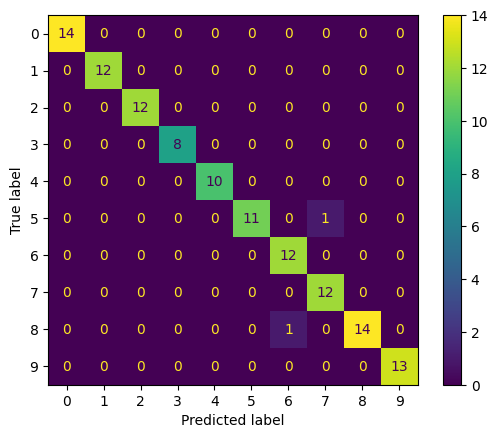

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

confusion, accuracy = 0, 0

for idx in range(3):
    SIG_train_l, SIG_test_l = train_test_split(SIG_entry_l, test_size=0.33, random_state=42 + idx)
    conf, acc = F_evaluation_recognition(SIG_test_l, SIG_train_l, gamma=gamma)
    confusion += conf
    accuracy += acc

print('')
# print(confusion)
ConfusionMatrixDisplay(confusion).plot()
print(accuracy/3)

### Protocol 2

From the same single dataset (here `SIG_entry_l`), we create
- a reference set  containing **only one pronunciation** of each number
- the remaining repetitions are used for the unkown set.
- The procedure is repeated by rotating the unkown and reference sets.

This protocol aims at evaluating the generalization capabilities of the recognition system.

100%|██████████| 110/110 [00:03<00:00, 28.56it/s]



0.846969696969697


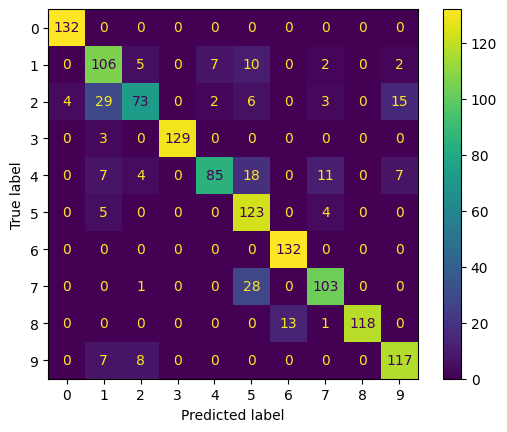

In [27]:
confusion, accuracy = 0, 0

labels = set(entry['label'] for entry in SIG_entry_l)
for idx in range(12):
    SIG_train_l = []
    for label in labels:
        entries_with_label = [entry for entry in SIG_entry_l if entry['label'] == label]
        SIG_train_l.append(random.choice(entries_with_label))
    SIG_test_l = [entry for entry in SIG_entry_l if entry not in SIG_train_l]
    conf, acc = F_evaluation_recognition(SIG_test_l, SIG_train_l, gamma=gamma)
    confusion += conf
    accuracy += acc

print('')
# print(confusion)
ConfusionMatrixDisplay(confusion).plot()
print(accuracy/12)

### Protocol 3

We use here two different datasets corresponding to two different speakers.
- the `SIG_entry_l` is used as the reference set and
- the `SIG2_entry_l` (a different speaker) as the unkown set.
- The procedure is repeated by inversing the role of the two sets.

This protocol aims at evaluating the generalization capabilities on a dataset containing data from the two speakers.

100%|██████████| 120/120 [00:30<00:00,  3.95it/s]



0.4791666666666667


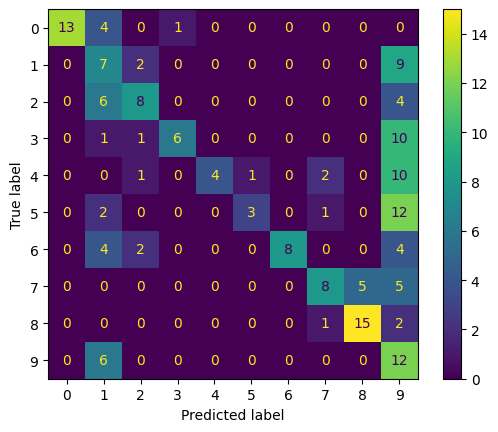

In [29]:
confusion, accuracy = 0, 0
conf, acc = F_evaluation_recognition(SIG2_entry_l, SIG_entry_l, gamma=gamma)
confusion += conf
accuracy += acc
conf, acc = F_evaluation_recognition(SIG_entry_l, SIG2_entry_l, gamma=gamma)
confusion += conf
accuracy += acc

print('')
# print(confusion)
ConfusionMatrixDisplay(confusion).plot()
print(accuracy/2)

# Questions:

- Evaluate the speech recognition performance with protocol 1 on the data ```SIG```, and then on the data ```SIG2```. What are the confusions ? What value of $\gamma$ parameter offers the best results ?
- Evaluate the generalization capabilities using protocol 2 on the data ```SIG```, and then on the data ```SIG2```. What do you notice?
- Evaluate the generalization capabilities to other speakers using protocol 3 on ```SIG_MIXED```. Explain the results.
- What are the limitations of dynamic time warping approaches for speech recognition that you have identified during this lab ? Propose possible solutions to these problems.